In [3]:
!pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 24.9 MB/s eta 0:00:00


In [11]:
# -*- coding: utf-8 -*-

# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.metrics import dtw, cdist_dtw # tslearn: 시계열 DTW 거리 계산
from tslearn.neighbors import KNeighborsTimeSeriesClassifier # tslearn: DTW 기반 KNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
import random
import os
import xgboost as xgb
from collections import Counter
import tensorflow as tf

# 시드 고정
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# imblearn: 불균형 데이터 처리 관련 라이브러리
from imblearn.metrics import specificity_score # imblearn: 특이도(다수 클래스 재현율) 계산

# 두 시계열 데이터 사이의 합성 샘플 생성 함수 (선형 보간)
def generate_synthetic_sample(ts1, ts2, alpha=0.5):
    return ts1 + alpha * (ts2 - ts1)

# --- 데이터 로드 ---
print("데이터 로드 중...")
# 제공해주신 경로에서 CSV 파일을 읽어옵니다.
df_X_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/X_train_sample100.csv')
df_y_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/y_train_sample100.csv')
df_X_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/X_test_sample100.csv')
df_y_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/y_test_sample100.csv')
print("데이터 로드 완료.")

# 데이터 numpy 배열로 변환 및 시계열 모델용 차원 추가
X_train = df_X_train.values
y_train = df_y_train.values.ravel()
X_test = df_X_test.values
y_test = df_y_test.values.ravel()

# 시계열 모델 (LSTM, CNN, tslearn KNN)은 (samples, timesteps, features) 형태를 사용
X_train_ts = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_ts = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 클래스 비율 확인 및 소수/다수 클래스 식별 (y_train 기준)
class_counts = Counter(y_train)
print(f"\n훈련 데이터 클래스 분포: {class_counts}")

sorted_classes = class_counts.most_common()
majority_class = sorted_classes[0][0]
minority_class = sorted_classes[-1][0]

print(f"소수 클래스: {minority_class}, 다수 클래스: {majority_class}")

# 소수 클래스 및 다수 클래스 인덱스 분리
minority_indices = np.where(y_train == minority_class)[0]
majority_indices = np.where(y_train == majority_class)[0]

X_minority_ts = X_train_ts[minority_indices] # 소수 클래스 샘플 피처
X_majority_ts = X_train_ts[majority_indices] # 다수 클래스 샘플 피처

# --- DTW 기반 Borderline SMOTE (안전 샘플 증강) ---
# k 값 설정 (이웃 탐색 개수)
k_neighbors = min(len(X_train_ts) - 1, 5)

# 소수 클래스 샘플 vs 전체 훈련 데이터 DTW 거리 계산
dtw_dist_minority_all = cdist_dtw(X_minority_ts, X_train_ts, n_jobs=-1)

# 소수 클래스 샘플을 '안전 샘플'로 분리 (k 이웃 중 소수 < 다수)
safe_minority_original_indices = []

for i in range(len(X_minority_ts)):
    current_minority_dist_row = dtw_dist_minority_all[i, :]
    sorted_indices = np.argsort(current_minority_dist_row)
    k_neighbor_original_indices = sorted_indices[1 : k_neighbors + 1]

    if len(k_neighbor_original_indices) > 0:
        k_neighbor_classes = y_train[k_neighbor_original_indices]
        num_minority_neighbors = np.sum(k_neighbor_classes == minority_class)
        num_majority_neighbors = np.sum(k_neighbor_classes == majority_class)

        if num_minority_neighbors < num_majority_neighbors:
            safe_minority_original_indices.append(minority_indices[i])

X_safe_minority_ts = X_train_ts[safe_minority_original_indices]
print(f"안전 소수 클래스 샘플 수: {len(X_safe_minority_ts)}")

# 안전 샘플과 가장 가까운 다수 클래스 샘플 사이에 데이터 증강
synthetic_samples = []
synthetic_labels = []

# 증강 데이터 변수를 원본 훈련 데이터로 초기화 (합성 데이터 없을 경우 대비)
X_augmented_ts = X_train_ts
y_augmented = y_train

if len(X_safe_minority_ts) > 0:
    # 안전 소수 클래스 샘플 vs 다수 클래스 샘플 DTW 거리 계산
    dtw_dist_safe_minority_majority = cdist_dtw(X_safe_minority_ts, X_majority_ts, n_jobs=-1)

    # 생성할 합성 데이터 총 개수 결정 (소수 클래스 수를 다수 클래스 수와 같게 만듦)
    target_minority_count = len(X_majority_ts)
    current_minority_count = len(X_minority_ts)
    num_samples_to_generate = target_minority_count - current_minority_count

    if num_samples_to_generate > 0:
         samples_per_safe_sample_base = num_samples_to_generate // len(X_safe_minority_ts)
         remainder = num_samples_to_generate % len(X_safe_minority_ts)

         for i in range(len(X_safe_minority_ts)):
            safe_sample_ts = X_safe_minority_ts[i]
            # 현재 안전 샘플에 가장 가까운 다수 클래스 샘플 찾기
            closest_majority_idx_in_majority_list = np.argmin(dtw_dist_safe_minority_majority[i, :])
            closest_majority_sample_ts = X_majority_ts[closest_majority_idx_in_majority_list]

            # 현재 안전 샘플 당 생성할 샘플 개수 결정
            num_to_generate_this_sample = samples_per_safe_sample_base
            if remainder > 0:
                num_to_generate_this_sample += 1
                remainder -= 1

            # 합성 샘플 생성 (선형 보간)
            for _ in range(num_to_generate_this_sample):
                alpha = random.random()
                synthetic_sample = generate_synthetic_sample(safe_sample_ts, closest_majority_sample_ts, alpha=alpha)
                synthetic_samples.append(synthetic_sample)
                synthetic_labels.append(minority_class)

# 생성된 합성 데이터가 있으면 원래 데이터와 합치기
if synthetic_samples:
    X_synthetic_ts = np.array(synthetic_samples)
    y_synthetic = np.array(synthetic_labels)
    print(f"생성된 합성 데이터 수: {len(X_synthetic_ts)}")
    X_augmented_ts = np.concatenate([X_train_ts, X_synthetic_ts], axis=0)
    y_augmented = np.concatenate([y_train, y_synthetic], axis=0)
    print(f"증강된 훈련 데이터 shape (시계열): {X_augmented_ts.shape}")
    print(f"증강된 훈련 레이블 shape: {y_augmented.shape}")

# 표준 모델 학습을 위한 데이터 (flattened) 준비
X_augmented = X_augmented_ts.reshape(X_augmented_ts.shape[0], -1)
X_test_flat = X_test_ts.reshape(X_test_ts.shape[0], -1)

# --- 모델 정의 및 학습 함수 ---

def predict_with_logistic_regression(X_train_data, y_train_data, X_test_data):
    print("Logistic Regression 모델 학습 중...")
    model = LogisticRegression(max_iter=2000, solver='liblinear', random_state=42)
    model.fit(X_train_data, y_train_data)
    print("Logistic Regression 모델 학습 완료.")
    return model.predict(X_test_data)

def predict_with_cart(X_train_data, y_train_data, X_test_data):
    print("CART 모델 학습 중...")
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train_data, y_train_data)
    print("CART 모델 학습 완료.")
    return model.predict(X_test_data)

def predict_with_knn(X_train_data_ts, y_train_data, X_test_data_ts):
    print("KNN (DTW) 모델 학습 중...")
    n_knn_neighbors = min(len(y_train_data), 5) if len(y_train_data) > 0 else 1
    if n_knn_neighbors < 1: n_knn_neighbors = 1
    model = KNeighborsTimeSeriesClassifier(n_neighbors=n_knn_neighbors, metric="dtw", n_jobs=-1)
    model.fit(X_train_data_ts, y_train_data)
    print("KNN (DTW) 모델 학습 완료.")
    return model.predict(X_test_data_ts)


def predict_with_xgboost(X_train_data, y_train_data, X_test_data):
    print("XGBoost 모델 학습 중...")
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic', random_state=42)
    model.fit(X_train_data, y_train_data)
    print("XGBoost 모델 학습 완료.")
    return model.predict(X_test_data)


def predict_with_lstm(X_train_data_ts, y_train_data, X_test_data_ts):
    print("LSTM 모델 학습 중...")
    unique_train_classes = np.unique(y_train_data)
    all_possible_classes = np.unique(np.concatenate([y_train_data, y_test]))
    num_classes = len(all_possible_classes)
    y_train_one_hot = to_categorical(y_train_data, num_classes=num_classes)

    input_shape = (X_train_data_ts.shape[1], X_train_data_ts.shape[2])

    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train_data_ts, y_train_one_hot, epochs=50, batch_size=32, verbose=0)
    print("LSTM 모델 학습 완료.")
    pred_probs = model.predict(X_test_data_ts)
    return np.argmax(pred_probs, axis=1)


def predict_with_cnn(X_train_data_ts, y_train_data, X_test_data_ts):
    print("CNN 모델 학습 중...")
    unique_train_classes = np.unique(y_train_data)
    all_possible_classes = np.unique(np.concatenate([y_train_data, y_test]))
    num_classes = len(all_possible_classes)
    y_train_one_hot = to_categorical(y_train_data, num_classes=num_classes)

    input_shape = (X_train_data_ts.shape[1], X_train_data_ts.shape[2])

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train_data_ts, y_train_one_hot, epochs=50, batch_size=32, verbose=0)
    print("CNN 모델 학습 완료.")
    pred_probs = model.predict(X_test_data_ts)
    return np.argmax(pred_probs, axis=1)


# --- 예측 결과 저장 및 성능 평가 ---

print("\n\n--- 모델별 성능 평가 결과 ---")

predictions = {}

X_train_for_flat = X_augmented
y_train_for_flat = y_augmented
X_test_for_flat = X_test_flat
X_train_for_ts = X_augmented_ts
y_train_for_ts = y_augmented
X_test_for_ts = X_test_ts

predictions["Logistic Regression"] = predict_with_logistic_regression(X_train_for_flat, y_train_for_flat, X_test_for_flat)
predictions["CART"] = predict_with_cart(X_train_for_flat, y_train_for_flat, X_test_for_flat)
predictions["KNN (DTW)"] = predict_with_knn(X_train_for_ts, y_train_for_ts, X_test_for_ts)
predictions["XGBoost"] = predict_with_xgboost(X_train_for_flat, y_train_for_flat, X_test_for_flat)
predictions["LSTM"] = predict_with_lstm(X_train_for_ts, y_train_for_ts, X_test_for_ts)
predictions["CNN"] = predict_with_cnn(X_train_for_ts, y_train_for_ts, X_test_for_ts)



데이터 로드 중...
데이터 로드 완료.

훈련 데이터 클래스 분포: Counter({np.int64(1): 1172, np.int64(0): 62})
소수 클래스: 0, 다수 클래스: 1
안전 소수 클래스 샘플 수: 61
생성된 합성 데이터 수: 1110
증강된 훈련 데이터 shape (시계열): (2344, 80, 1)
증강된 훈련 레이블 shape: (2344,)


--- 모델별 성능 평가 결과 ---
Logistic Regression 모델 학습 중...
Logistic Regression 모델 학습 완료.
CART 모델 학습 중...
CART 모델 학습 완료.
KNN (DTW) 모델 학습 중...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KNN (DTW) 모델 학습 완료.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


XGBoost 모델 학습 중...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:42:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost 모델 학습 완료.
LSTM 모델 학습 중...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM 모델 학습 완료.
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
CNN 모델 학습 중...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN 모델 학습 완료.
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step



--- Logistic Regression 모델 성능 ---
모델 성능 평가:
  정확도: 0.6026
  F1-Score (소수 클래스 0): 0.4778
  재현율 (Recall, 소수 클래스 0): 0.4699
  특이도 (Specificity, 다수 클래스 1): 0.4699
  혼동 행렬 (Confusion Matrix):
[[156 176]
 [165 361]]


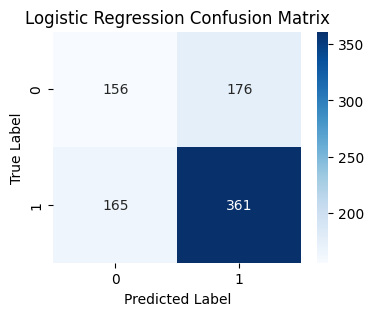


--- CART 모델 성능 ---
모델 성능 평가:
  정확도: 0.6492
  F1-Score (소수 클래스 0): 0.3499
  재현율 (Recall, 소수 클래스 0): 0.2440
  특이도 (Specificity, 다수 클래스 1): 0.2440
  혼동 행렬 (Confusion Matrix):
[[ 81 251]
 [ 50 476]]


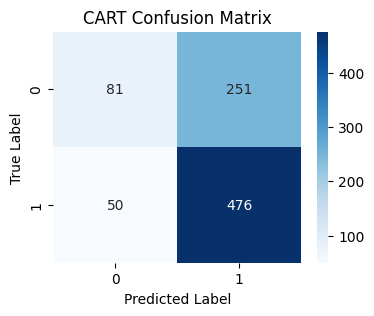


--- KNN (DTW) 모델 성능 ---
모델 성능 평가:
  정확도: 0.6294
  F1-Score (소수 클래스 0): 0.5108
  재현율 (Recall, 소수 클래스 0): 0.5000
  특이도 (Specificity, 다수 클래스 1): 0.5000
  혼동 행렬 (Confusion Matrix):
[[166 166]
 [152 374]]


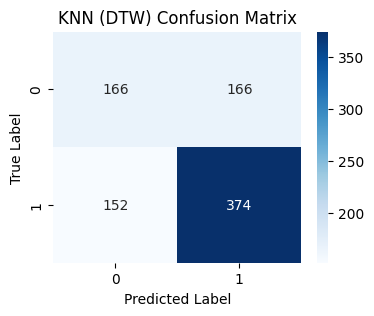


--- XGBoost 모델 성능 ---
모델 성능 평가:
  정확도: 0.6655
  F1-Score (소수 클래스 0): 0.2914
  재현율 (Recall, 소수 클래스 0): 0.1777
  특이도 (Specificity, 다수 클래스 1): 0.1777
  혼동 행렬 (Confusion Matrix):
[[ 59 273]
 [ 14 512]]


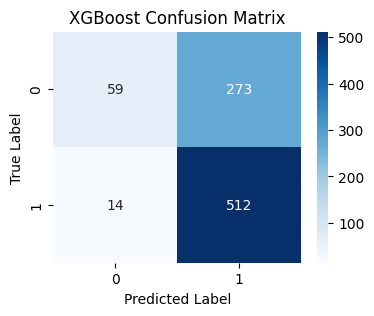


--- LSTM 모델 성능 ---
모델 성능 평가:
  정확도: 0.5781
  F1-Score (소수 클래스 0): 0.6039
  재현율 (Recall, 소수 클래스 0): 0.8313
  특이도 (Specificity, 다수 클래스 1): 0.8313
  혼동 행렬 (Confusion Matrix):
[[276  56]
 [306 220]]


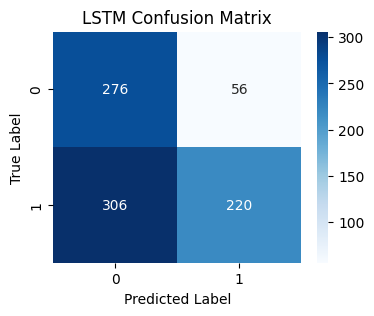


--- CNN 모델 성능 ---
모델 성능 평가:
  정확도: 0.6713
  F1-Score (소수 클래스 0): 0.3761
  재현율 (Recall, 소수 클래스 0): 0.2560
  특이도 (Specificity, 다수 클래스 1): 0.2560
  혼동 행렬 (Confusion Matrix):
[[ 85 247]
 [ 35 491]]


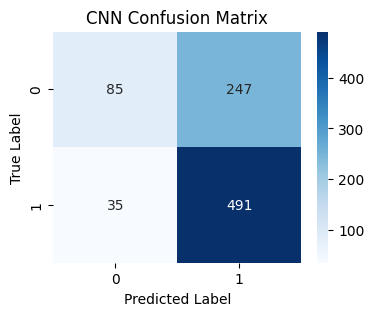

In [12]:
for model_name, pred_y in predictions.items():
    accuracy = accuracy_score(y_test, pred_y)
    # Recall: 소수 클래스(minority_class)에 대한 재현율
    recall = recall_score(y_test, pred_y, pos_label=minority_class, zero_division=0)
    # F1-Score: 소수 클래스(minority_class)에 대한 F1 점수
    f1 = f1_score(y_test, pred_y, pos_label=minority_class, zero_division=0)

    # Specificity: 다수 클래스(majority_class)에 대한 재현율 (True Negative Rate)
    specificity = specificity_score(y_test, pred_y, pos_label=majority_class)

    conf_matrix = confusion_matrix(y_test, pred_y)

    print(f"\n--- {model_name} 모델 성능 ---")
    print("모델 성능 평가:")
    print(f"  정확도: {accuracy:.4f}")
    print(f"  F1-Score (소수 클래스 {minority_class}): {f1:.4f}")
    print(f"  재현율 (Recall, 소수 클래스 {minority_class}): {recall:.4f}")
    print(f"  특이도 (Specificity, 다수 클래스 {majority_class}): {specificity:.4f}")
    print("  혼동 행렬 (Confusion Matrix):")
    print(conf_matrix)

    # Confusion Matrix 시각화
    plt.figure(figsize=(4, 3))
    cm = confusion_matrix(y_test, pred_y)
    all_labels_unique = np.unique(np.concatenate([y_test, pred_y]))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=all_labels_unique, yticklabels=all_labels_unique)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()